In [2]:
#@title Imports and installiations 

from IPython.display import clear_output
import pandas as pd
import numpy as np
from matplotlib import pyplot
from collections import deque
from sklearn import preprocessing
import random
import requests
import os


!pip install keras-tuner --upgrade


clear_output()

In [ ]:
#@title Report results via telegram bot API
def notify(text='Task Finished',token,chat_id):
  data = {'chat_id': chat_id, 'text': text}
  url = f'https://api.telegram.org/bot{token}/sendMessage'
  response = requests.get(url, params=data)
  print(response.json())

def send_document(doc,,token,chat_id):
    files = {'document': open(doc, 'rb')}
    URL = "https://api.telegram.org/bot{}/".format(token)
    requests.post(URL + "sendDocument?chat_id={}".format(chat_id), files=files)

def send_photo(doc,token,chat_id):
    files = {'photo': open(doc, 'rb')}
    URL = "https://api.telegram.org/bot{}/".format(token)
    requests.post(URL + "sendPhoto?chat_id={}".format(chat_id), files=files)
    print(response.json())

In [ ]:
#@title Constatnts
token  = "YOUR BOT TOKEN"
chat_id= "YOUR TELEGRAM CHAT ID"

In [3]:
#@title Getting the csv file name dirty way! (inside google colab dir)
table_list=[]
new_table_list=[]
for filename in os.listdir("/content/"):
    if filename.endswith('.csv'):
        table_list.append(pd.read_csv(filename,sep="|"))
        new_table_list.append(filename[:-4])

file_name=new_table_list[0]


data = pd.read_csv(f'/content/{file_name}.csv',parse_dates=True)
data=data.rename({'<OPEN>':'OPEN','<CLOSE>':'CLOSE','<FIRST>': 'FIRST', '<HIGH>': 'HIGH','<LOW>':'LOW','<VALUE>':'VALUE','<VOL>':'VOLUME','<OPENINT>':'OPENINT','<LAST>':'LAST','<DTYYYYMMDD>':'Date'}, axis=1)  # new method
data.drop(['<PER>','<TICKER>','VALUE','OPENINT','LAST'],axis=1,inplace=True)#These Columns are either redundent or Duplicates ex. CLOSE==LAST
#data['Date']=pd.to_datetime(data['Date'])
data.head()

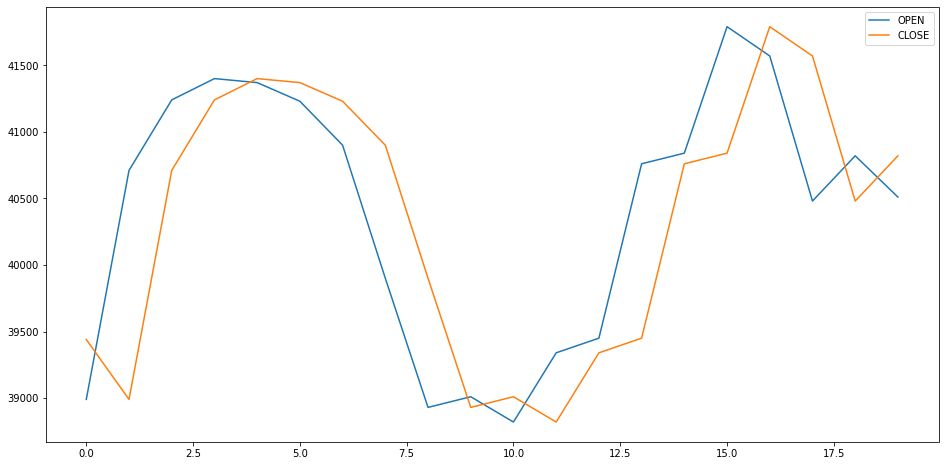

In [6]:
data[['OPEN','CLOSE']][0:20].plot.line(figsize=(16,8))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225 entries, 0 to 3224
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3225 non-null   int64  
 1   FIRST   3225 non-null   float64
 2   HIGH    3225 non-null   float64
 3   LOW     3225 non-null   float64
 4   CLOSE   3225 non-null   float64
 5   VOLUME  3225 non-null   int64  
 6   OPEN    3225 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 176.5 KB


In [8]:
data.isnull().sum()

Date      0
FIRST     0
HIGH      0
LOW       0
CLOSE     0
VOLUME    0
OPEN      0
dtype: int64

In [9]:
data['FC']=(data['CLOSE']-data['OPEN'])/data['OPEN']
data['FH'] = (data['HIGH']-data['OPEN'])/data['OPEN']
data['FL']=(data['OPEN']-data['LOW'])/data['OPEN']

In [10]:
data.head(3)

,Date,FIRST,HIGH,LOW,CLOSE,VOLUME,OPEN,FC,FH,FL
0,20211214,37500.0,40440.0,37500.0,39440.0,925231,38990.0,0.011541,0.037189,0.038215
1,20211213,39520.0,40480.0,38680.0,38990.0,2139469,40710.0,-0.042250,-0.005650,0.049865
2,20211212,41010.0,41300.0,40420.0,40710.0,468926,41240.0,-0.012852,0.001455,0.019884


In [11]:
data =data[['FC','FH', 'FL',"CLOSE"]]

In [12]:
data = data.iloc[len(data)-1000:len(data),:]
data

,FC,FH,FL,CLOSE
2225,-0.000621,0.038796,0.006828,3220.0
2226,-0.000310,-0.007136,0.007136,3222.0
2227,-0.002167,-0.008978,0.009288,3223.0
2228,-0.028863,-0.028863,0.028863,3230.0
2229,-0.004788,-0.033513,0.033513,3326.0
...,...,...,...,...
3220,0.012643,0.012643,-0.012538,19303.0
3221,0.014368,0.014368,-0.014261,19062.0
3222,0.002347,0.002347,-0.000427,18792.0
3223,-0.000107,0.000000,0.000160,18748.0


In [14]:
data.fillna(method='ffill', inplace=True)

In [15]:
data.isnull().sum()

FC       0
FH       0
FL       0
CLOSE    0
dtype: int64

In [16]:
data['target']=data['CLOSE'].shift(-1)
price = data[['target']]

In [17]:
data

,FC,FH,FL,CLOSE,target
2225,-0.000621,0.038796,0.006828,3220.0,3222.0
2226,-0.000310,-0.007136,0.007136,3222.0,3223.0
2227,-0.002167,-0.008978,0.009288,3223.0,3230.0
2228,-0.028863,-0.028863,0.028863,3230.0,3326.0
2229,-0.004788,-0.033513,0.033513,3326.0,3342.0
...,...,...,...,...,...
3220,0.012643,0.012643,-0.012538,19303.0,19062.0
3221,0.014368,0.014368,-0.014261,19062.0,18792.0
3222,0.002347,0.002347,-0.000427,18792.0,18748.0
3223,-0.000107,0.000000,0.000160,18748.0,18750.0


In [18]:
#@title Scaling the Data
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)
norm_data

array([[5.66036539e-03],
       [5.66671109e-03],
       [5.71113099e-03],
       [6.32031830e-03],
       [6.42184952e-03],
       [6.46626943e-03],
       [6.51703503e-03],
       [6.94854271e-03],
       [6.95488841e-03],
       [7.15160515e-03],
       [7.15795085e-03],
       [7.17064225e-03],
       [7.18333365e-03],
       [7.18967935e-03],
       [7.18967935e-03],
       [7.24044496e-03],
       [7.25948206e-03],
       [7.41812459e-03],
       [7.44350740e-03],
       [7.53234721e-03],
       [7.53869291e-03],
       [7.67195264e-03],
       [7.67829834e-03],
       [7.67195264e-03],
       [7.66560693e-03],
       [7.66560693e-03],
       [7.67829834e-03],
       [7.68464404e-03],
       [7.79886666e-03],
       [7.98289199e-03],
       [8.25575714e-03],
       [8.52227658e-03],
       [8.64284490e-03],
       [8.65553631e-03],
       [8.71264762e-03],
       [8.72533902e-03],
       [8.72533902e-03],
       [8.68091911e-03],
       [8.71899332e-03],
       [9.01089557e-03],


In [19]:
#@title A function to univareite the raw dataset into data (train) and label numpy arrays

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [20]:
#@title Train test splitting
past_history = 3
future_target = 0

TRAIN_SPLIT = int(len(norm_data) * 0.8)


x_train, y_train = univariate_data(norm_data,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

x_test, y_test = univariate_data(norm_data,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

In [21]:
#@titel Defining mutiple  models with different parameters and actiovations for achieveing the best score and accurate model 

from keras.models import Sequential
from kerastuner.tuners import RandomSearch , BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import Dense, LSTM, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
import time
from tensorflow.keras.optimizers import Adam


Root="/content/Picklsz"

LOG_DIR=f"{Root}/__{file_name}__{int(time.time())}"

#learning_rate = 0.0001



# def build_model(hp):
#   model = Sequential()
#   model.add(LSTM(units = hp.Int("Input_units", min_value=32, max_value=128, step=32), activation=hp.Choice('actTivation FUnc', ['tanh', 'sigmoid'])))
#   if hp.Boolean("dropout"):
#     model.add(Dropout(rate=hp.Float("DropOut_ratio",min_value=0.1,max_value=0.5,step=0.1)))
#   model.add(Dense(units = 1))
#   model.compile(loss='mse', optimizer=Adam(hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),metrics=['mse'])
#   return model

# tuner=RandomSearch(
#     build_model,
#     objective="loss",
#     max_trials=10,
#     executions_per_trial=1,
#     directory=LOG_DIR
# )

# batch_size = 5
# num_epochs = 100

# tuner.search(
#     x_train,
#     y_train,
#     validation_split=0.1,
#     batch_size=batch_size,
#     epochs=num_epochs,
   
# )

# #



from tensorflow import keras
from kerastuner.tuners import BayesianOptimization

def build_model(hp):
  model = Sequential()
  model.add(LSTM(units=hp.Int('units',min_value=32,max_value=512,step=32),activation=hp.Choice('actTivation FUnc', ['tanh', 'sigmoid'])))
  model.add(Dense(units=hp.Int('units',min_value=32,max_value=512,step=32), activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])))
  return model

tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=20,
    executions_per_trial=1,
    directory=LOG_DIR)


batch_size = 5
num_epochs = 100

tuner.search(
    x_train, y_train,
    epochs=num_epochs,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]


Trial 10 Complete [00h 00m 23s]
mse: 9.795014193514362e-05

Best mse So Far: 9.727216820465401e-05
Total elapsed time: 00h 06m 50s
INFO:tensorflow:Oracle triggered exit


In [22]:
#@title Saving the optimized Model into a pickle file object
import pickle
tuner_path=f"{Root}/tuner_{file_name}_{int(time.time())}.pkl"
with open(tuner_path,"wb") as f:
  pickle.dump(tuner, f)
print(tuner.get_best_hyperparameters()[0].values)
print("\n"*3,"=======================================")
print(tuner.results_summary())

{'units': 32, 'actTivation FUnc': 'tanh', 'learning_rate': 0.01}



Results summary
Results in /content/Picklsz/__Oroumiyeh.Cem.__1639682284/untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units: 32
actTivation FUnc: tanh
learning_rate: 0.01
Score: 9.727216820465401e-05
Trial summary
Hyperparameters:
units: 32
actTivation FUnc: tanh
learning_rate: 0.01
Score: 9.795014193514362e-05
Trial summary
Hyperparameters:
units: 32
actTivation FUnc: tanh
learning_rate: 0.01
Score: 9.819302795222029e-05
Trial summary
Hyperparameters:
units: 128
actTivation FUnc: tanh
learning_rate: 0.01
Score: 9.908992797136307e-05
Trial summary
Hyperparameters:
units: 32
actTivation FUnc: sigmoid
learning_rate: 0.01
Score: 0.00010183915583183989
Trial summary
Hyperparameters:
units: 512
actTivation FUnc: tanh
learning_rate: 0.01
Score: 0.00010186160216107965
Trial summary
Hyperparameters:
units: 512
actTivation FUnc: sigmoid
learning_rate: 0.01
Score: 

In [23]:
#@title Choosing the best model for forcasting and predictions
model=tuner.get_best_models()[0]

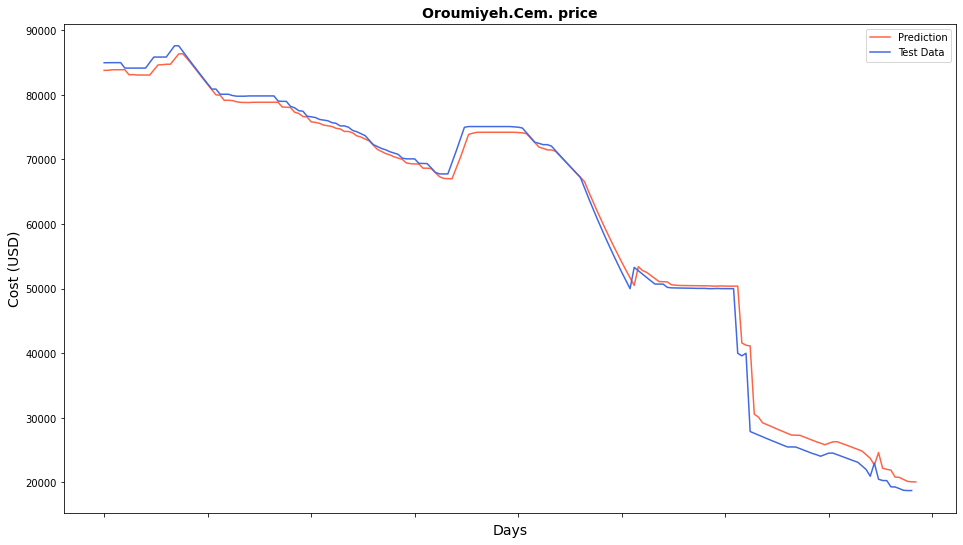

In [29]:
#@title Visauliaztions 
import seaborn as sns
import  matplotlib.pyplot as plt
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))

figname=f"{Root}/File.png"
fig,ax=plt.subplots(figsize=(16,9))
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')
ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
ax.set_title(f'{file_name} price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)
plt.savefig(figname)

In [30]:
#@title Saving the model into root directory
model.save(f'{Root}')

INFO:tensorflow:Assets written to: /content/Picklsz/assets


INFO:tensorflow:Assets written to: /content/Picklsz/assets


In [31]:
#@title zipping the models 
import subprocess

bashCommand = f"zip -r picklz.zip {Root}"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [ ]:
#@title notifiying the finished trainings using telegram bot api
send_photo(figname)
notify(f"{file_name} ==> Result + Files :")
send_document("picklz.zip")
send_document(tuner_path)